# TCN for all position

In [1]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
import numpy as np
from collections import OrderedDict
import os
import random
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from callback import tcn
from callback import earlystopping

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 乱数固定用の処理
# 同じ学習結果を得る
seed = 42


os.environ['PYTHONHASHSEED'] = str(seed)
# Python random
random.seed(seed)
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data

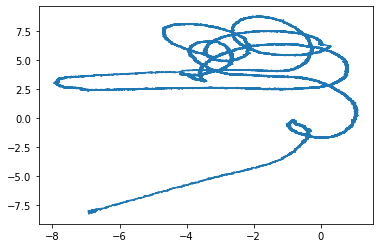

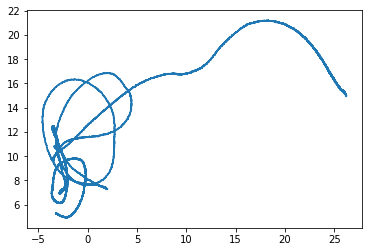

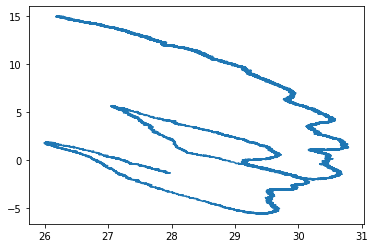

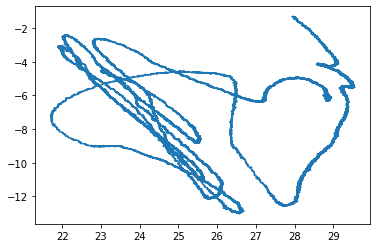

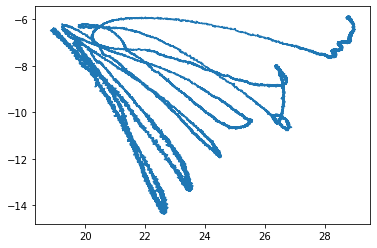

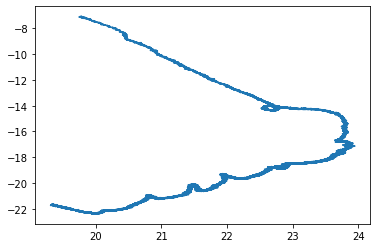

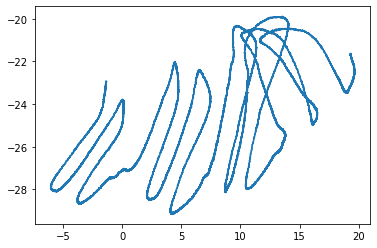

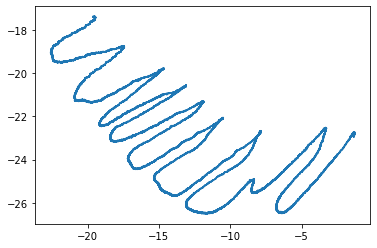

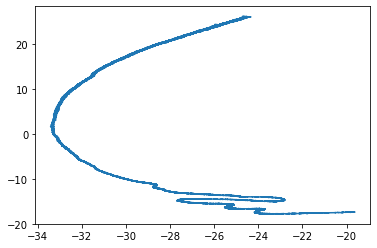

In [3]:
def mk_dataframe(path):
    df = pd.read_table(path, sep=" ", header=None)
    df = df.drop(columns=0, axis=1)
    df = df.drop(columns=3, axis=1)
    return df

position_data = np.array([[None, None]])

for i in range(9):
    df = mk_dataframe("230724/pos-{}.dat".format(i))
    df_ = df.values
    position_data = np.concatenate([position_data, df_])
    plt.plot(df_[:,0], df_[:,1])
    plt.show()

In [4]:
position_data = position_data[1:]

In [5]:
position_data.shape

(323705, 2)

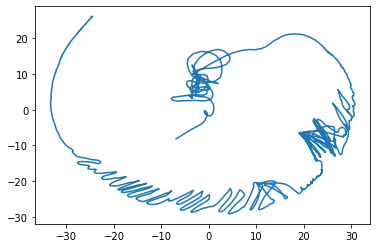

In [6]:
# 10秒に1点
plt.plot(position_data[::100,0], position_data[::100,1])

In [7]:
position_data_by10s = position_data[::100]

In [8]:
position_data_by10s.shape

(3238, 2)

### position data, scatter marker by 10 seconds

Text(0.5, 1.0, 'position data \n scatter x by 10 seconds')

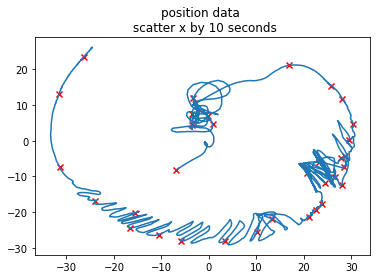

In [9]:
plt.plot(position_data_by10s[:,0], position_data_by10s[:,1])
# plt.scatter(position_data_by10s[0,0], position_data_by10s[0,1])
for i in range(0, len(position_data_by10s), 100):
    plt.scatter(position_data_by10s[i,0], position_data_by10s[i,1], marker="x", color="red")
    
plt.title("position data \n scatter x by 10 seconds")

### Data be analized
**ランダムな運動を排除**

In [10]:
# position_data_by10s = position_data_by10s[600:]

Text(0.5, 1.0, 'data be analyzed (without randomness)')

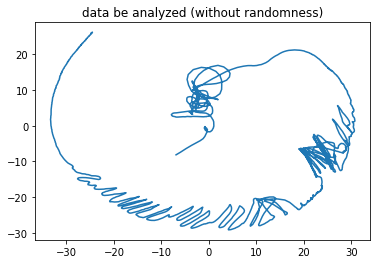

In [11]:
plt.plot(position_data_by10s[:,0], position_data_by10s[:,1])
plt.title("data be analyzed (without randomness)")

In [12]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

pos_by10s_scaled = scaler.fit_transform(position_data_by10s)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
time_step = 200

len_seq = len(pos_by10s_scaled)
data_size = len_seq - time_step

data = np.zeros((data_size, 2, time_step))
t = np.zeros((data_size, 2))

In [14]:
for i in range(data_size):
    data[i,0] = pos_by10s_scaled[i:i+time_step, 0]
    data[i,1] = pos_by10s_scaled[i:i+time_step, 1]
    t[i] = pos_by10s_scaled[i+time_step]

In [15]:
data

array([[[4.12351166e-01, 4.26921301e-01, 4.45205855e-01, ...,
         5.29659882e-01, 5.31386717e-01, 5.31583872e-01],
        [3.79866248e-01, 3.93155798e-01, 4.11332961e-01, ...,
         6.22926531e-01, 6.18588241e-01, 6.14744698e-01]],

       [[4.26921301e-01, 4.45205855e-01, 4.63674891e-01, ...,
         5.31386717e-01, 5.31583872e-01, 5.32243563e-01],
        [3.93155798e-01, 4.11332961e-01, 4.28109213e-01, ...,
         6.18588241e-01, 6.14744698e-01, 6.11136491e-01]],

       [[4.45205855e-01, 4.63674891e-01, 4.79096939e-01, ...,
         5.31583872e-01, 5.32243563e-01, 5.32180966e-01],
        [4.11332961e-01, 4.28109213e-01, 4.40609045e-01, ...,
         6.14744698e-01, 6.11136491e-01, 6.07562534e-01]],

       ...,

       [[6.85900070e-04, 8.97843821e-04, 9.84097125e-04, ...,
         1.34471341e-01, 1.33325478e-01, 1.36319182e-01],
        [5.68151451e-01, 5.73547440e-01, 5.77578460e-01, ...,
         9.94448064e-01, 9.96700606e-01, 9.96383813e-01]],

       [[8.97843821

In [16]:
# 使用するテンソル
x = torch.Tensor(np.array(data).reshape(-1, 2, time_step)).to(device)
t = torch.Tensor(np.array(t).reshape(-1, 2)).to(device)

In [17]:
x.shape

torch.Size([3038, 2, 200])

## Train and Evaluate

In [18]:
def train(model, optimizer, lr, epoch, clip=-1):
    model.train()
    batch_idx = 1 # バッチが何回カウントされたか
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x, debug=False)
        
        # 出力と正解の誤差をバッチの数で割る（バッチにおける誤差の平均）
        loss = F.mse_loss(output, y)
        loss.backward()
        if clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % 100 == 0:
            cur_loss = total_loss / batch_idx
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            # total_loss = 0
            
    return total_loss / batch_idx
            
def evaluate(epoch, train_loss):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        if epoch % 5 == 0 or epoch == 1:
            print('\n [epoch: {}] Train loss: {:.6f} \t Test set: Average loss: {:.6f}\n'.format(epoch, train_loss, test_loss.item()))
        return test_loss.item()

In [19]:
n_seq = x.size(0)

train_size = int(n_seq * 0.9)
test_size = n_seq - train_size
print("train size:{}, test size: {}".format(train_size, test_size))
X_train, Y_train = x[:train_size], t[:train_size]
X_test, Y_test = x[train_size:], t[train_size:]

train size:2734, test size: 304


## Model

In [20]:
batch_size = 64
epochs = 75
lr = 1e-3

model = tcn.myTCN(input_size=2, output_size=2, num_channels=[15]*7, kernel_size=5, dropout=0.0)
optimizer = getattr(optim, 'Adam')(model.parameters(), lr=lr)

In [21]:
loss = {"val_loss":[], "train_loss":[]}
es = earlystopping.EarlyStopping(patience=5, verbose=1)

for epoch in range(1, epochs + 1):
    train_loss = train(model, optimizer, lr=lr, epoch=epoch, clip=-1)
    tloss = evaluate(epoch, train_loss)
    
    loss["train_loss"].append(train_loss)
    loss["val_loss"].append(tloss)
    # if es(tloss):
    #     break


 [epoch: 1] Train loss: 0.148122 	 Test set: Average loss: 0.314401


 [epoch: 5] Train loss: 0.049331 	 Test set: Average loss: 0.285993


 [epoch: 10] Train loss: 0.041887 	 Test set: Average loss: 0.284948


 [epoch: 15] Train loss: 0.015221 	 Test set: Average loss: 0.130801


 [epoch: 20] Train loss: 0.001532 	 Test set: Average loss: 0.041211


 [epoch: 25] Train loss: 0.000827 	 Test set: Average loss: 0.042338


 [epoch: 30] Train loss: 0.000852 	 Test set: Average loss: 0.031674


 [epoch: 35] Train loss: 0.000922 	 Test set: Average loss: 0.025419


 [epoch: 40] Train loss: 0.001064 	 Test set: Average loss: 0.046840


 [epoch: 45] Train loss: 0.001187 	 Test set: Average loss: 0.029703


 [epoch: 50] Train loss: 0.000755 	 Test set: Average loss: 0.019682


 [epoch: 55] Train loss: 0.001047 	 Test set: Average loss: 0.016917


 [epoch: 60] Train loss: 0.000721 	 Test set: Average loss: 0.024336


 [epoch: 65] Train loss: 0.000890 	 Test set: Average loss: 0.030968


 [epoch

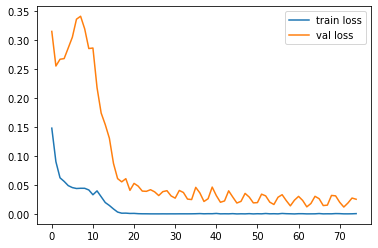

In [22]:
plt.plot(loss["train_loss"], label="train loss")
plt.plot(loss["val_loss"], label="val loss")
plt.legend()

In [23]:
gen_time = 500

gen = [[None, None] for i in range(time_step)]
z = X_test[0].reshape(1,2,-1)

for i in range(gen_time):
    model.eval()
    pred = model(z).data.cpu().numpy()
    z = np.concatenate([z.numpy().reshape(2,-1), pred.reshape(2,-1)], 1)
    z = z[:,1:]
    # print(z.shape)
    z = torch.Tensor(z.reshape(1,2,-1))
    gen.append([pred[0,0], pred[0,1]])

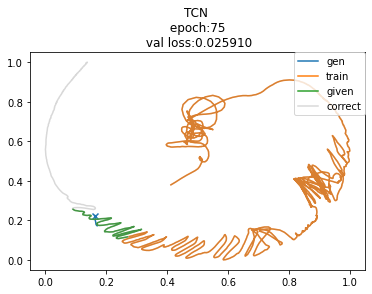

In [24]:
gen = np.array(gen)
plt.plot(gen[:,0], gen[:,1], label="gen")
plt.scatter(gen[time_step,0], gen[time_step, 1], marker="x")


plot_train = X_train[:,:,0].numpy()
plt.plot(plot_train[:,0], plot_train[:,1], label="train")
plt.plot(X_test[0,0], X_test[0,1], label="given")
plt.plot(pos_by10s_scaled[:,0], pos_by10s_scaled[:,1], color="gray", alpha=0.3, label="correct")
plt.title("TCN \n epoch:{} \n val loss:{:6f}".format(epochs, loss["val_loss"][-1]))
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0)

In [141]:
loss["val_loss"][-1]

0.0037061707116663456

In [132]:
gen

array([[None, None],
       [None, None],
       [None, None],
       ...,
       [0.07544109, 0.3184669],
       [0.07544109, 0.3184669],
       [0.07544109, 0.3184669]], dtype=object)

In [68]:
aa = X_train[:,:,0].numpy()

In [71]:
aa[:,0]

array([0.4122115 , 0.4268706 , 0.44522965, ..., 0.4624895 , 0.47083595,
       0.47837132], dtype=float32)

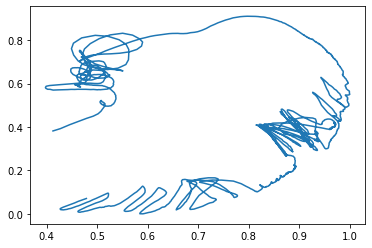

In [72]:
plt.plot(aa[:,0], aa[:,1])